In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time
import dateutil.parser

from matplotlib import gridspec
import scipy.optimize as sciop
import json
from scipy.stats import mode

import lightkurve as lk
from lightkurve import search_targetpixelfile

from astroquery.mast import Observations

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

from scipy.stats import binned_statistic
import corner

%matplotlib inline

In [2]:
#get only TESS stars observed at 2-minute cadence within 12deg of the southern ecliptic pole
obs_2min = Observations.query_criteria(obs_collection = 'TESS', sequence_number=[0,1,2,3,4,5,6,7,8,9,10,11,12,13],t_exptime = [120], dataproduct_type = "timeseries")#, s_region="CIRCLE IRCS 90.0 -66.5607 12.0")

Not enough values provided, skipping... [astroquery.mast.discovery_portal]


In [3]:
ecliptic_pole_dist = np.arccos(np.sin(obs_2min['s_dec'] * (np.pi/180.))*np.sin(-66.5607 * (np.pi/180.)) + np.cos(obs_2min['s_dec'] * (np.pi/180.))*np.cos(-66.5607 * (np.pi/180.))*np.cos((obs_2min['s_ra'] - 90.)*(np.pi/180.)))
ecliptic_mask = ((ecliptic_pole_dist*(180./np.pi)) < 12.)

#ecliptic_mask = (obs_2min['s_ra'] > 84.0) & (obs_2min['s_ra'] < 96.0) & (obs_2min['s_dec'] > -72.5607) & (obs_2min['s_dec'] < -60.5607)
obs_2min = obs_2min[ecliptic_mask]
print(type(obs_2min))
print(obs_2min.colnames)
print(len(obs_2min))

<class 'astropy.table.table.Table'>
['dataproduct_type', 'calib_level', 'obs_collection', 'obs_id', 'target_name', 's_ra', 's_dec', 't_min', 't_max', 't_exptime', 'wavelength_region', 'filters', 'em_min', 'em_max', 'target_classification', 'obs_title', 't_obs_release', 'instrument_name', 'proposal_pi', 'proposal_id', 'proposal_type', 'project', 'sequence_number', 'provenance_name', 's_region', 'jpegURL', 'dataURL', 'dataRights', 'mtFlag', 'srcDen', 'intentType', 'obsid', 'objID']
84955


In [4]:
unique, unique_idxs = np.unique(obs_2min['target_name'], return_index=True)

obs_2min_unique = obs_2min[unique_idxs]

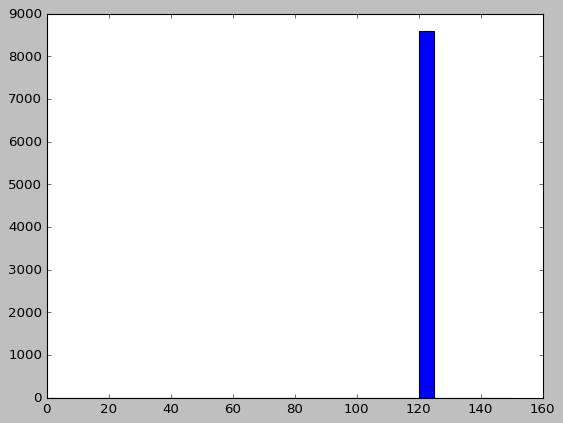

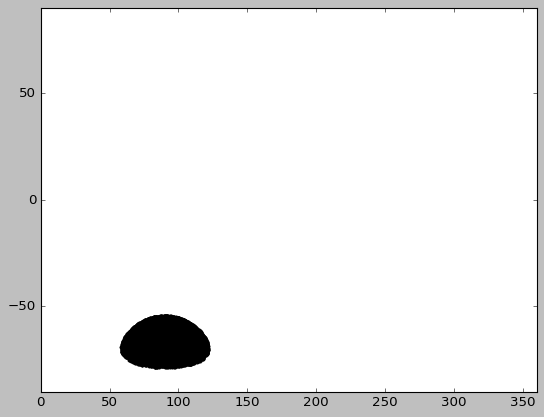

In [5]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.hist(obs_2min_unique['t_exptime'],range=(0,150),bins=30)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(obs_2min_unique['s_ra'],obs_2min_unique['s_dec'],'k.')
ax.set_xlim(0.,360)
ax.set_ylim(-90.,90.)
plt.show()

In [6]:
print(len(obs_2min_unique))

8590


In [7]:
print(obs_2min_unique['target_name','obs_id'][0:10])

target_name                      obs_id                    
----------- -----------------------------------------------
  139369107 tess2018292075959-s0004-0000000139369107-0124-s
  139369333 tess2018292075959-s0004-0000000139369333-0124-s
  139369433 tess2018206045859-s0001-0000000139369433-0120-s
  139369436 tess2018206045859-s0001-0000000139369436-0120-s
  139369634 tess2018206045859-s0001-0000000139369634-0120-s
  139370537 tess2018206045859-s0001-0000000139370537-0120-s
  139370701 tess2018206045859-s0001-0000000139370701-0120-s
  139371053 tess2018292075959-s0004-0000000139371053-0124-s
  139371265 tess2018206045859-s0001-0000000139371265-0120-s
  139371600 tess2018206045859-s0001-0000000139371600-0120-s


In [42]:
np.savetxt("./TESS_southern_ecliptic_pole_postage_stamps.txt",obs_2min_unique['target_name','s_ra','s_dec'],fmt='%s,%f,%f')

# then used https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html to crossmatch the above with the TIC to get the other stellar columns, resulting in:

In [2]:
tessStars = Table.read("./southern_ecliptic_pole_TIC_crossmatch.csv")
print(tessStars.colnames)
print(len(tessStars))
goodMatchIdxs = (tessStars['TESSID'] == tessStars['MatchID'])
tessStars = tessStars[goodMatchIdxs]
print(len(tessStars))

['TESSID', 'RA', 'dec', 'MatchID', 'MatchRa', 'MatchDEC', 'dstArcSec', 'version', 'HIP', 'TYC', 'UCAC', 'TWOMASS', 'SDSS', 'ALLWISE', 'GAIA', 'APASS', 'KIC', 'objType', 'typeSrc', 'POSflag', 'pmRA', 'e_pmRA', 'pmDEC', 'e_pmDEC', 'PMflag', 'plx', 'e_plx', 'PARflag', 'gallong', 'gallat', 'eclong', 'eclat', 'Bmag', 'e_Bmag', 'Vmag', 'e_Vmag', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag', 'TWOMflag', 'prox', 'w1mag', 'e_w1mag', 'w2mag', 'e_w2mag', 'w3mag', 'e_w3mag', 'w4mag', 'e_w4mag', 'GAIAmag', 'e_GAIAmag', 'Tmag', 'e_Tmag', 'TESSflag', 'SPFlag', 'Teff', 'e_Teff', 'logg', 'e_logg', 'MH', 'e_MH', 'rad', 'e_rad', 'mass', 'e_mass', 'rho', 'e_rho', 'lumclass', 'lum', 'e_lum', 'd', 'e_d', 'ebv', 'e_ebv', 'numcont', 'contratio', 'disposition', 'duplicate_id', 'priority', 'eneg_EBV', 'epos_EBV', 'EBVflag', 'eneg_Mass', 'epos_Mass', 'eneg_Rad', 'epos_Rad', 'eneg_rho', 'epos_rho', 'eneg_logg', 'epos

In [3]:
Tmag = np.array(tessStars['Tmag'])
dist = np.array(tessStars['d'])
teff = np.array(tessStars['Teff'])
feh = np.array(tessStars['MH'])
logg = np.array(tessStars['logg'])
Vmag = np.array(tessStars['Vmag'])
Bmag = np.array(tessStars['Bmag'])
ID = np.array(tessStars['TESSID'])

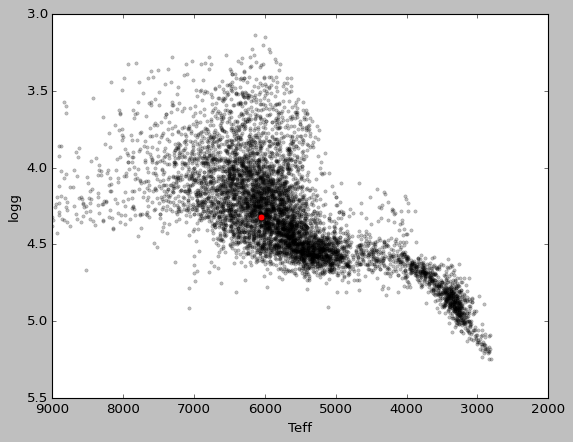

In [4]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
#ax.plot(Bmag - Vmag, Vmag, 'k.',alpha=0.25)
#ax.set_xlabel("B-V")
#ax.set_ylabel("V")
#ax.invert_yaxis()
#ax.set_xlim(-2,4)

#show location of TIC 167691903 to make sure it's not a giant
#ax.plot(11.022-10.565,10.565,'ro')


ax.plot(teff,logg,'k.',alpha=0.25)
ax.set_xlabel('Teff')
ax.set_ylabel('logg')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlim(9000,2000)
ax.set_ylim(5.5,3.0)
#show location of TIC 167691903 to make sure it's not a giant
ax.plot(6060.18,4.32289,'ro')

plt.show()

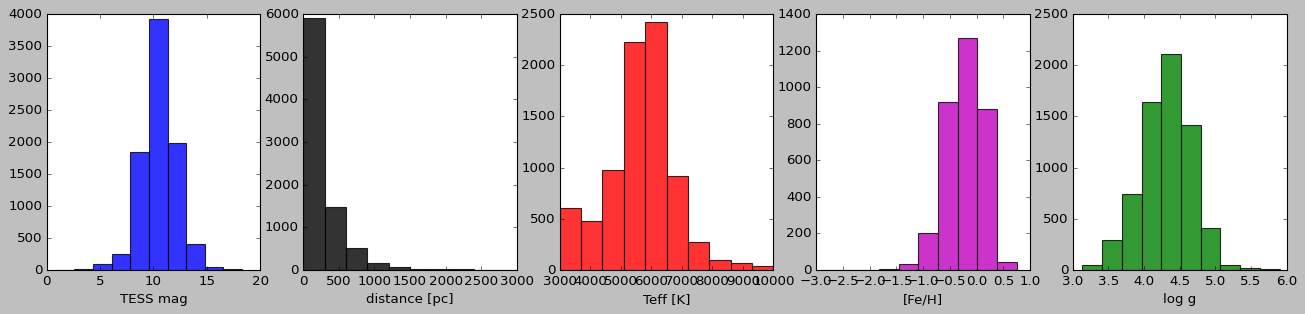

In [5]:
fig, axes = plt.subplots(1,5,figsize=(20,4))

axes[0].hist(Tmag,color='b',alpha=0.8)
axes[1].hist(dist,range=(0,3000),color='k',alpha=0.8)
axes[2].hist(teff,color='r',alpha=0.8,range=(3000,10000))
axes[3].hist(feh,color='m',alpha=0.8)
axes[4].hist(logg,color='g',alpha=0.8)

axes[0].set_xlabel('TESS mag')
axes[1].set_xlabel('distance [pc]')
axes[2].set_xlabel('Teff [K]')
axes[3].set_xlabel('[Fe/H]')
axes[4].set_xlabel('log g')

plt.show()

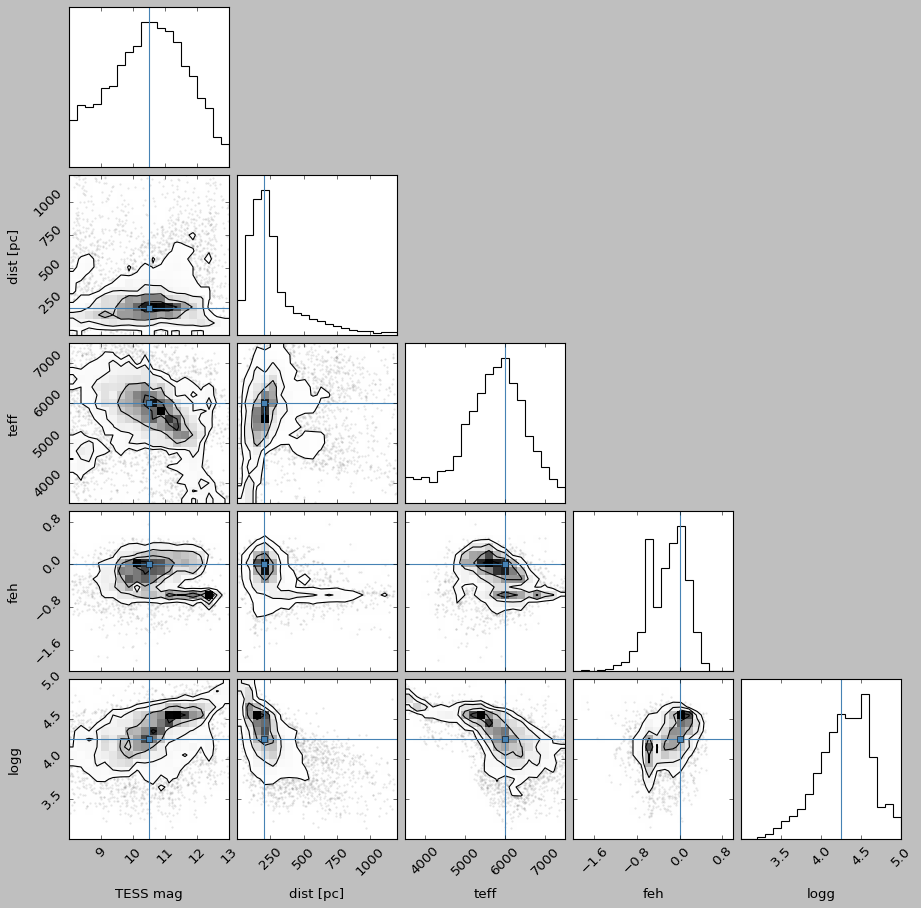

In [6]:
fig = corner.corner(np.vstack((Tmag,dist,teff,feh,logg)).T,labels=['TESS mag', 'dist [pc]','teff','feh','logg'],
                    truths=[10.5, 200, 6000, 0,4.25],
                    range=[(8,13),(0,1200),(3500,7500),(-2.0,1.0),(3,5)])
plt.show()

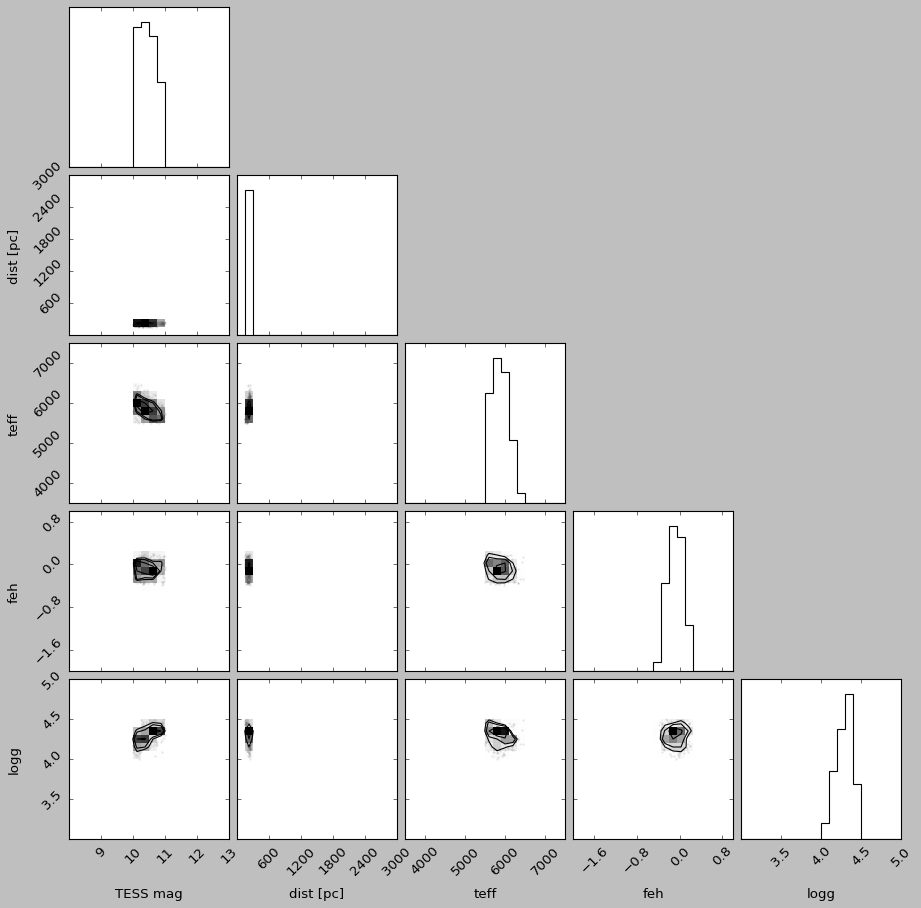

In [7]:
# make some cuts to get at the densest part of the distribution
peakMask = (Tmag > 10) & (Tmag < 11) & (dist > 150) & (dist < 250) & (teff > 5500) & (teff < 6500) & (feh > -0.4) & (feh < 0.2) & (logg > 4) & (logg < 4.5)

fig = corner.corner(np.vstack((Tmag[peakMask],dist[peakMask],teff[peakMask],feh[peakMask],logg[peakMask])).T,labels=['TESS mag', 'dist [pc]','teff','feh','logg'],range=[(8,13),(0,3000),(3500,7500),(-2.0,1.0),(3,5)])
plt.show()

In [8]:
print(len(Tmag))
print(len(Tmag[peakMask]))

8589
337


In [66]:
# grab 10 random TIC identifiers from the "peak" sample

#Note that 30 min cadenced data is only available for TESS Cycles 1 and 2, 
#the 10 min cadence data in Cycles 3 and 4, and the 200 sec data in Cycle 5+. 
#(from https://heasarc.gsfc.nasa.gov/docs/tess/community-tools.html)
"""
testIDs = np.random.choice(ID[peakMask], 10)

for tic in testIDs:
    #print(tic)
    searchResult = lk.search_lightcurve("TIC {0}".format(tic))
    exptime = searchResult.exptime.value
    
    cad2minMask = (exptime == 120.)
    #print(searchResult)
    #print(searchResult[cad2minMask])
    
    lc = searchResult[cad2minMask].download()
    lc.plot()
"""    

'\ntestIDs = np.random.choice(ID[peakMask], 10)\n\nfor tic in testIDs:\n    #print(tic)\n    searchResult = lk.search_lightcurve("TIC {0}".format(tic))\n    exptime = searchResult.exptime.value\n    \n    cad2minMask = (exptime == 120.)\n    #print(searchResult)\n    #print(searchResult[cad2minMask])\n    \n    lc = searchResult[cad2minMask].download()\n    lc.plot()\n'

In [9]:
# data for this star: F8-G0
print(tessStars["Tmag","e_Tmag","d","e_d","Teff","e_Teff","logg","e_logg","MH","e_MH","rad","e_rad","mass","e_mass","Bmag","Vmag","lumclass"][tessStars["TESSID"] == 167691903])

  Tmag  e_Tmag    d     e_d     Teff   e_Teff   logg    e_logg      MH        e_MH     rad     e_rad   mass  e_mass   Bmag   Vmag  lumclass
------- ------ ------- ------ ------- ------- ------- --------- ---------- --------- ------- --------- ---- -------- ------ ------ --------
10.0451  0.006 181.007 0.6925 6060.18 114.434 4.32289 0.0769944 -0.0311195 0.0515745 1.21374 0.0545528 1.13 0.142905 11.022 10.565    DWARF


SearchResult containing 13 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 01 2018   SPOC     120   167691903      0.0
  1 TESS Sector 02 2018   SPOC     120   167691903      0.0
  2 TESS Sector 03 2018   SPOC     120   167691903      0.0
  3 TESS Sector 04 2018   SPOC     120   167691903      0.0
  4 TESS Sector 05 2018   SPOC     120   167691903      0.0
  5 TESS Sector 06 2018   SPOC     120   167691903      0.0
  6 TESS Sector 07 2019   SPOC     120   167691903      0.0
  7 TESS Sector 08 2019   SPOC     120   167691903      0.0
  8 TESS Sector 09 2019   SPOC     120   167691903      0.0
  9 TESS Sector 10 2019   SPOC     120   167691903      0.0
 10 TESS Sector 11 2019   SPOC     120   167691903      0.0
 11 TESS Sector 12 2019   SPOC     120   167691903      0.0
 12 TESS Sector 13 2019   SPOC     120   167691903      0

<class 'lightkurve.collections.LightCurveCollection'>
<class 'lightkurve.lightcurve.TessLightCurve'>
[136.22790313 124.43878088 121.00492232 124.90994939 127.12465361
 139.88655021 127.79566439 126.72863588 136.84898544 127.79113453
 140.4030664  127.93425436 135.43417437]


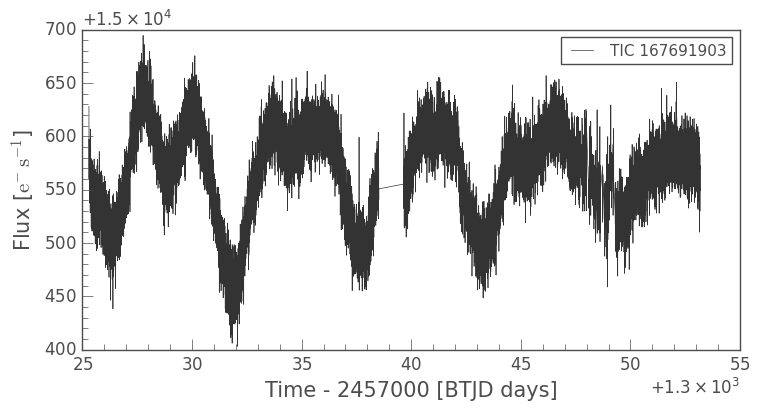

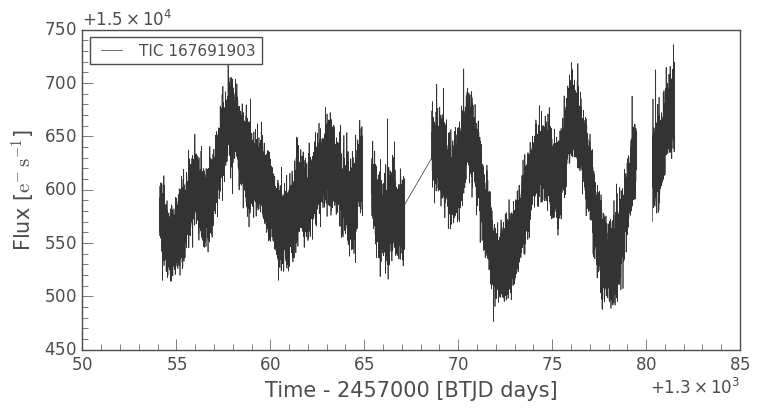

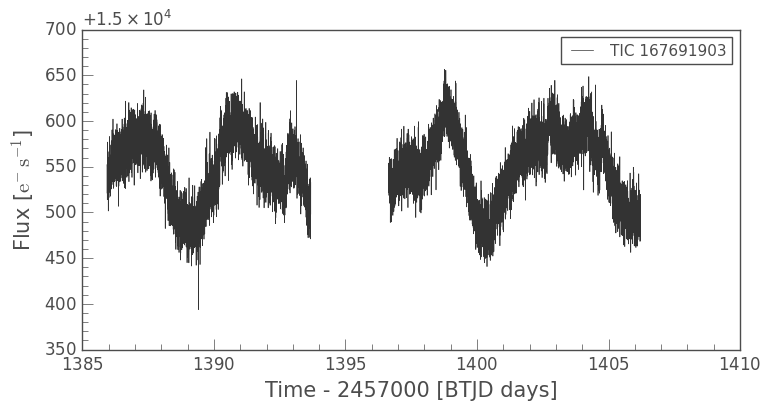

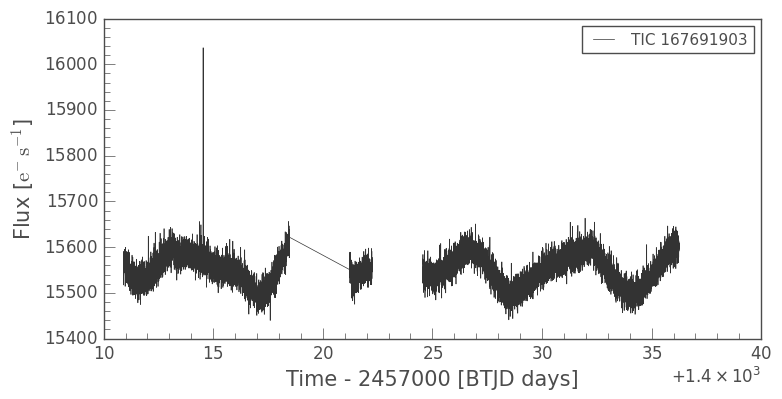

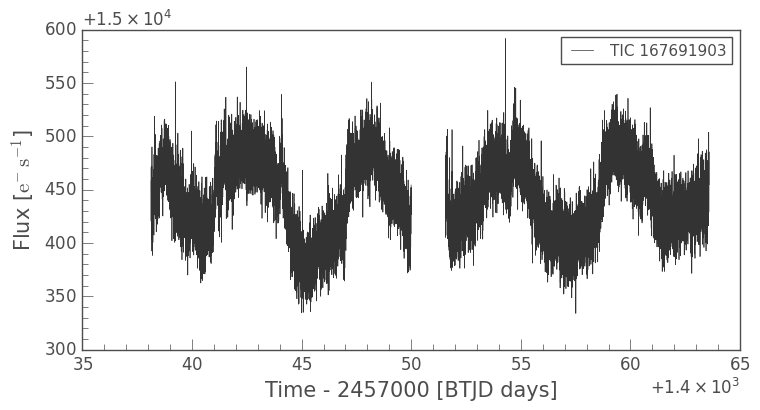

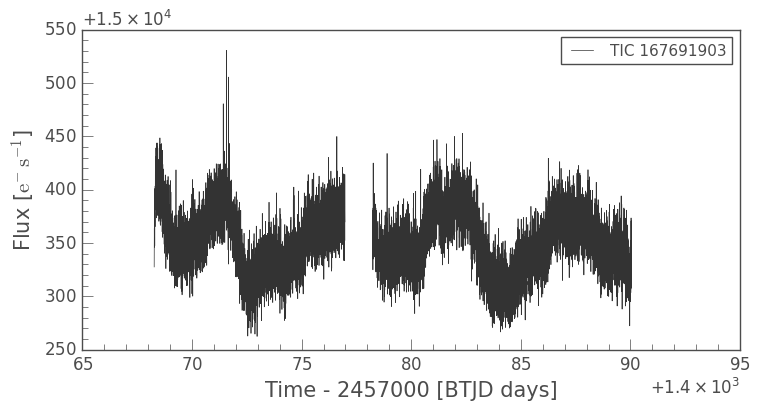

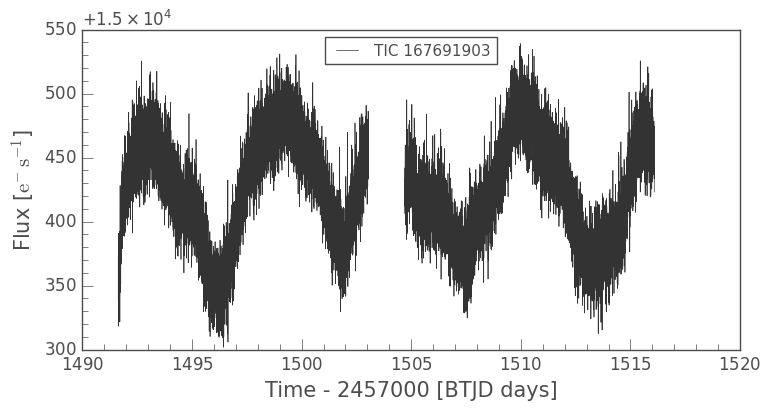

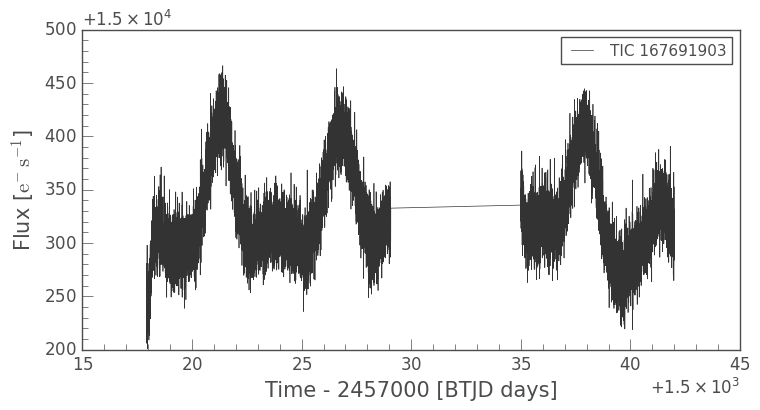

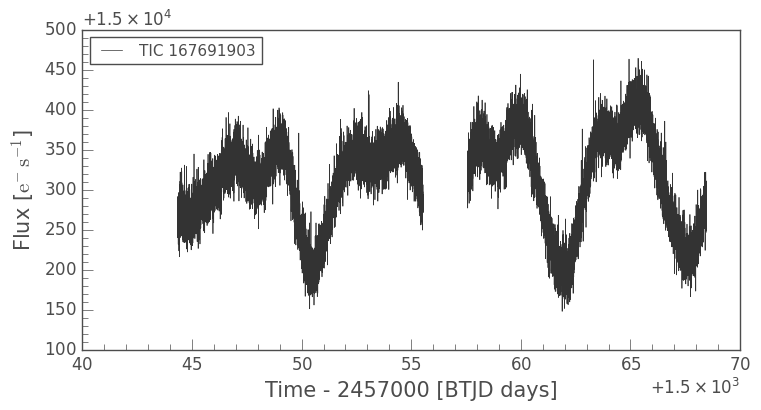

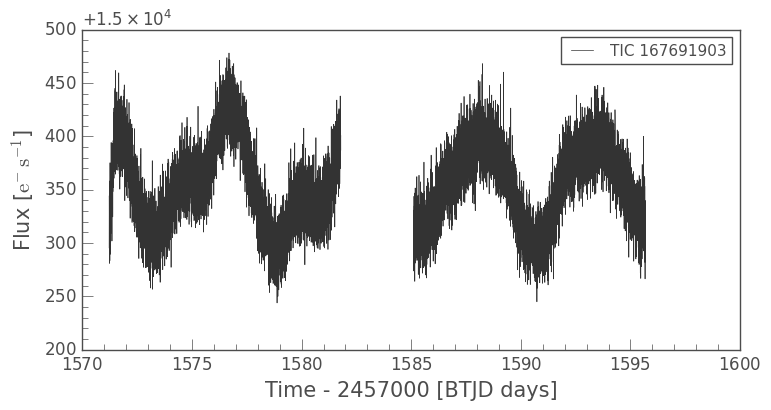

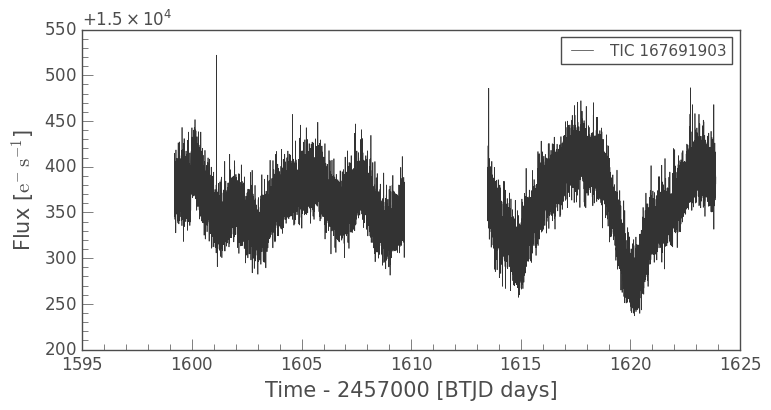

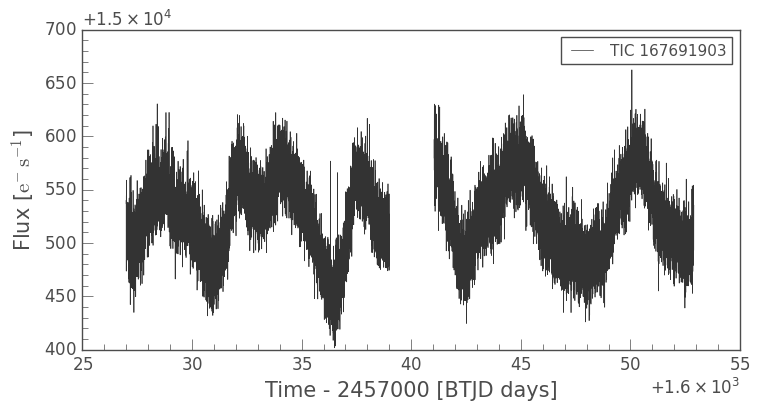

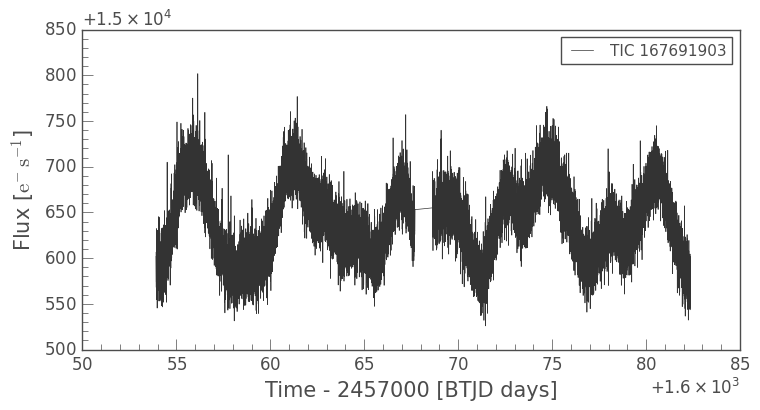

In [14]:
searchResult = lk.search_lightcurve("TIC 167691903",author="SPOC")
#print(searchResult)
exptime = searchResult.exptime.value
cad2minMask = (exptime == 120.)
print(searchResult[cad2minMask])
lcs = searchResult[cad2minMask].download_all()
print(type(lcs))
print(type(lcs[0]))

alltime = []
allflux = []
allfluxerr = []

cdpp1est = []

for lc in lcs:
    lc.plot()
    alltime = alltime + list(lc.time.value) #BTJD = BJD - 2457000.0
    allflux = allflux + list(lc.flux.value) #electrons/sec
    allfluxerr = allfluxerr + list(lc.flux_err.value) #electrons/sec
    cdpp1est.append(lc.estimate_cdpp(transit_duration=30).value) #transit duration in units of 2-minute cadence

alltime = np.array(alltime)
allflux = np.array(allflux)
allfluxerr = np.array(allfluxerr)

nonans = ~np.isnan(alltime) & ~np.isnan(allflux) & ~np.isnan(allfluxerr)
alltime = alltime[nonans]
allflux = allflux[nonans]
allfluxerr = allfluxerr[nonans]

cdpp1est = np.array(cdpp1est)
print(cdpp1est)



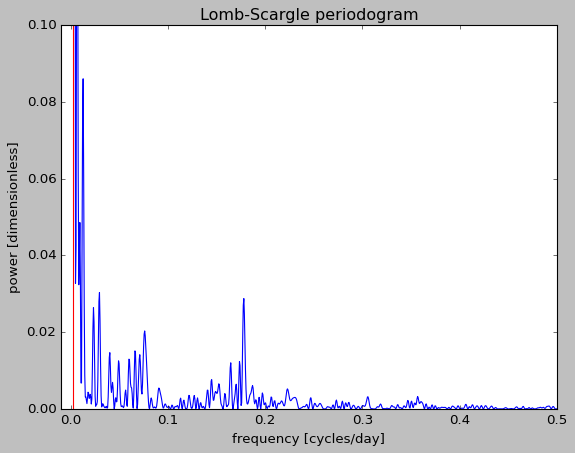

frequency of max power is 0.002800641771009633 day^-1
corresponding period is 357.0610173537116 day


In [15]:
# LS periodogram of signal
#max freq = (1./(2.*dt)), where dt = 2min * (1 day/(24*60min))
frequency, power = LombScargle(alltime,allflux).autopower(minimum_frequency=(1./(np.max(alltime)-np.min(alltime))), maximum_frequency=(1./(2.*0.0013889)))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(frequency,power)
ax.set_xlabel('frequency [cycles/day]')
ax.set_ylabel('power [dimensionless]')
ax.set_title('Lomb-Scargle periodogram')
ax.axvline(frequency[np.argmax(power)],color='r')
ax.set_xlim(-0.01,0.5)
ax.set_ylim(0,0.1)
plt.show()

print("frequency of max power is {0} day^-1".format(frequency[np.argmax(power)])) #frequency of max power in this case is 1 year
print("corresponding period is {0} day".format(1./frequency[np.argmax(power)]))

In [16]:
# based on by-eye inspection of rotational modulation, look at periods ~few days
# avoid tess sector cadence of 13.9d = freq of 0.0717
frequencySlice = (frequency > 0.1) & (frequency < 0.2)
powerSlice = power[frequencySlice]
#print(powerSlice[np.argmax(powerSlice)])
print(frequency[frequencySlice][np.argmax(powerSlice)])

test_per = 1./frequency[frequencySlice][np.argmax(powerSlice)]
print(test_per)

frequencySlice = (frequency > 0.3) & (frequency < 0.4)
powerSlice = power[frequencySlice]
#print(powerSlice[np.argmax(powerSlice)])
print(frequency[frequencySlice][np.argmax(powerSlice)])

test_per_half = 1./frequency[frequencySlice][np.argmax(powerSlice)]
print(test_per_half)

0.17812081663621265
5.614166939523766
0.35680176162662725
2.8026767453195567


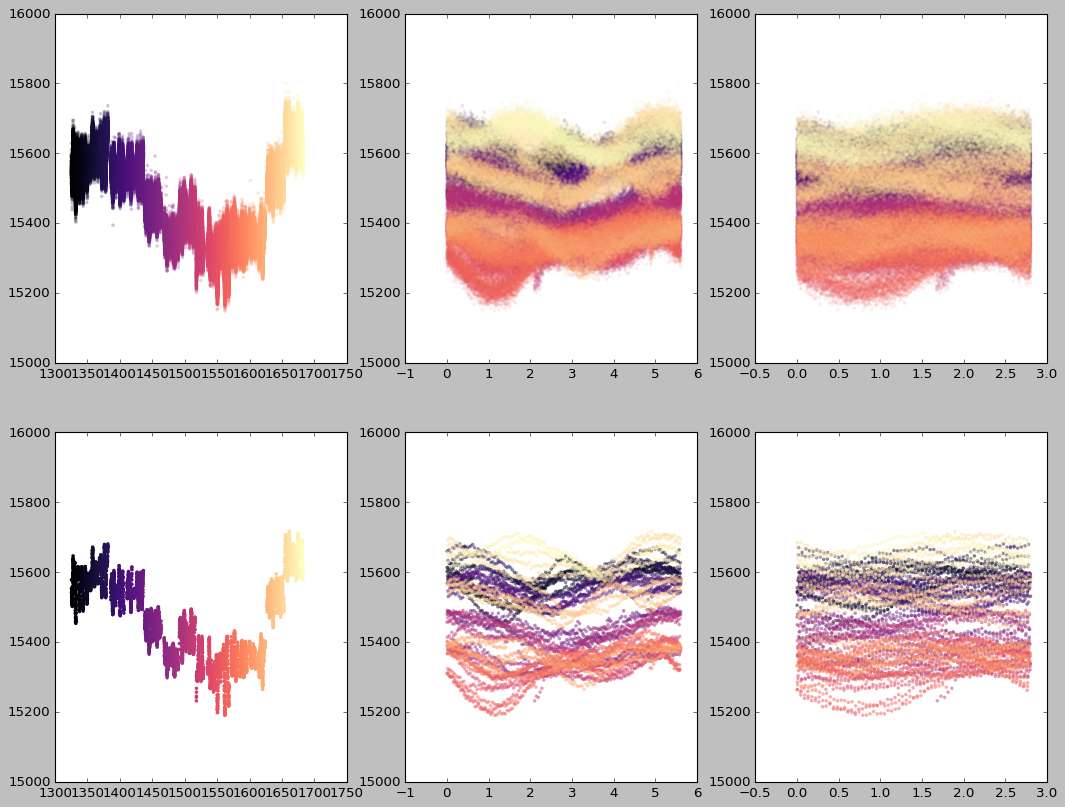

In [17]:
#phase fold the LC
fig, axes = plt.subplots(2,3,figsize=(16,12))
axes[0,0].scatter(alltime, allflux,c=alltime,s=10,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=0.25)
axes[0,1].scatter(alltime%test_per, allflux,c=alltime,s=10,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=0.1)
axes[0,2].scatter(alltime%test_per_half, allflux,c=alltime,s=10,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=0.1)

binned_flux, binned_t, binnumber = binned_statistic(alltime,allflux,statistic="median",bins=len(alltime)/25)
binned_t = (binned_t[1:] + binned_t[0:-1])/2.

axes[1,0].scatter(binned_t, binned_flux,c=binned_t,s=10,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=1)
axes[1,1].scatter(binned_t%test_per, binned_flux,c=binned_t,s=10,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=0.5)
axes[1,2].scatter(binned_t%test_per_half, binned_flux,c=binned_t,s=10,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=0.5)


for ax in np.ravel(axes):
    ax.set_ylim(15000,16000)
plt.show()

#not great!! this one does evolve, unlike the SPECULOOS M-dwarf

In [19]:
tosave = np.vstack((alltime.T + 2457000., allflux.T, allfluxerr.T)).T
print(np.shape(tosave))

(205351, 3)


In [21]:
# save data to file
np.savetxt("./TESS_style_F8.txt", tosave, fmt='%f', delimiter=" ", header="time[BJD] flux[e-/s] fluxerr[e-/s]")